# Comparing OLPS algorithms on a diversified set of ETFs

Let's compare the state of the art in OnLine Portfolio Selection (OLPS) algorithms and determine if they can enhance a rebalanced passive strategy in practice. [Online Portfolio Selection: A Survey by Bin Li and Steven C. H. Hoi](http://arxiv.org/abs/1212.2129) provides the most comprehensive review of multi-period portfolio allocation optimization algorithms.  The authors [developed](http://olps.stevenhoi.org/) the [OLPS Toolbox](  http://www.mysmu.edu.sg/faculty/chhoi/olps/OLPS_toolbox.pdf), but here we use [Mojmir Vinkler's](https://www.linkedin.com/profile/view?id=210899853) [implementation](https://github.com/Marigold/universal-portfolios)  and extend [his comparison](http://nbviewer.ipython.org/github/Marigold/universal-portfolios/blob/master/On-line%20portfolios.ipynb) to a more recent timeline with a set of ETFs to avoid survivorship bias (as suggested by [Ernie Chan](http://epchan.blogspot.cz/2007/01/universal-portfolios.html)) and idiosyncratic risk.

Vinkler does all the hard work in his [thesis](http://is.muni.cz/th/358102/prif_m/?lang=en;id=183901), and concludes  that Universal Portfolios work practically the same as Constant Rebalanced Portfolios, and work better for an uncorrelated set of small and volatile stocks.  Here I'm looking to find if any strategy is applicable to a set of ETFs.

The agorithms compared are:

Type | Name | Algo | Reference 
-------------------------|------|------|----
Benchmark | BAH | Buy and Hold |
Benchmark | CRP | Constant Rebalanced Portfolio | T. Cover. [Universal Portfolios](http://www-isl.stanford.edu/~cover/papers/paper93.pdf), 1991.
Benchmark | UCRP | Uniform CRP (UCRP), a special case of CRP with all weights being equal | T. Cover. [Universal Portfolios](http://www-isl.stanford.edu/~cover/papers/paper93.pdf), 1991.
Benchmark | BCRP | Best Constant Rebalanced Portfolio | T. Cover. [Universal Portfolios](http://www-isl.stanford.edu/~cover/papers/paper93.pdf), 1991.
Follow-the-Winner | UP | Universal Portfolio | T. Cover. [Universal Portfolios](http://www-isl.stanford.edu/~cover/papers/paper93.pdf), 1991.
Follow-the-Winner | EG | Exponential Gradient |  Helmbold, David P., et al. [On‐Line Portfolio Selection Using Multiplicative Updates](http://www.cis.upenn.edu/~mkearns/finread/helmbold98line.pdf) Mathematical Finance 8.4 (1998): 325-347.
Follow-the-Winner | ONS | Online Newton Step | A. Agarwal, E. Hazan, S. Kale, R. E. Schapire. [Algorithms for Portfolio Management based on the Newton Method](http://machinelearning.wustl.edu/mlpapers/paper_files/icml2006_AgarwalHKS06.pdf), 2006.
Follow-the-Loser | Anticor | Anticorrelation | A. Borodin, R. El-Yaniv, and V. Gogan. [Can we learn to beat the best stock](http://arxiv.org/abs/1107.0036), 2005
Follow-the-Loser |PAMR | Passive Aggressive Mean Reversion  |  B. Li, P. Zhao, S. C.H. Hoi, and V. Gopalkrishnan. [Pamr: Passive aggressive mean reversion strategy for portfolio selection](http://www.cais.ntu.edu.sg/~chhoi/paper_pdf/PAMR_ML_final.pdf), 2012.
Follow-the-Loser |CWMR | Confidence Weighted Mean Reversion |  B. Li, S. C. H. Hoi, P. L. Zhao, and V. Gopalkrishnan.[Confidence weighted mean reversion strategy for online portfolio selection](http://jmlr.org/proceedings/papers/v15/li11b/li11b.pdf), 2013.        
Follow-the-Loser | OLMAR | Online Moving Average Reversion| Bin Li and Steven C. H. Hoi [On-Line Portfolio Selection with Moving Average Reversion](http://arxiv.org/abs/1206.4626)
Follow-the-Loser |RMR | Robust Median Reversion | D. Huang, J. Zhou, B. Li, S. C.vH. Hoi, S. Zhou [Robust Median Reversion Strategy for On-Line Portfolio Selection](http://ijcai.org/papers13/Papers/IJCAI13-296.pdf), 2013.
Pattern Matching | Kelly | Kelly fractional betting |[Kelly Criterion](http://en.wikipedia.org/wiki/Kelly_criterion#Application_to_the_stock_market)
Pattern Matching | BNN | nonparametric nearest neighbor log-optimal | L. Gyorfi, G. Lugosi, and F. Udina. [Nonparametric kernel based sequential investment strategies](http://papers.ssrn.com/sol3/papers.cfm?abstract_id=889976). Mathematical Finance 16 (2006) 337–357.
Pattern Matching | CORN | correlation-driven nonparametric learning | B. Li, S. C. H. Hoi, and V. Gopalkrishnan. [Corn: correlation-driven nonparametric learning approach for portfolio selection](http://www.cais.ntu.edu.sg/~chhoi/paper_pdf/TIST-CORN.pdf), 2011.

We pick 6 ETFs to avoid survivorship bias and capture broad market diversification. We select the longest running ETF per assset class: [VTI](https://www.google.com/finance?q=VTI), [EFA](https://www.google.com/finance?q=EFA), [EEM](https://www.google.com/finance?q=EFA), [TLT](https://www.google.com/finance?q=TLT), [TIP](https://www.google.com/finance?q=TIP), [VNQ](https://www.google.com/finance?q=VNQ) .  We train and select the best parameters on market data from 2005-2012 inclusive (8 years), and test on 2013-2014 inclusive (2 years). 

In [ ]:
# You will first need to either download or install universal-portfolios from Vinkler
# one way to do it is uncomment the line below and execute
#!pip install --upgrade universal-portfolios 
# or
#!pip install --upgrade -e git+git@github.com:Marigold/universal-portfolios.git@master#egg=universal-portfolios
#
# if the above fail, git clone git@github.com:marigold/universal-portfolios.git and python setup.py install

In [ ]:
Initialize and set debugging level to `debug` to track progress.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import pandas_datareader as pdr
# data reader now seperated to new package. pip install pandas-datareader
#from pandas.io.data import DataReader
from datetime import datetime
import six
import universal as up
from universal import tools
from universal import algos
import logging
# we would like to see algos progress
logging.basicConfig(format='%(asctime)s %(message)s', level=logging.DEBUG)

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (16, 10) # increase the size of graphs
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['lines.linewidth'] = 1
default_color_cycle = mpl.rcParams['axes.color_cycle'] # save this as we will want it back later

/home/ros/.conda/envs/python35/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/home/ros/.conda/envs/python35/lib/python3.5/site-packages/matplotlib/__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [ ]:
# note what versions we are on:
import sys
print('Python: '+sys.version)
print('Pandas: '+pd.__version__)
import pkg_resources
print('universal-portfolios: '+pkg_resources.get_distribution("universal-portfolios").version)
print('Pandas Datareader:'+pdr.__version__)

# Loading the data

We want to train on market data from 2005-2012 inclusive (8 years), and test on 2013-2014 inclusive (2 years). But at this point we accept the default parameters for the respective algorithms and we essentially are looking at two independent time periods.  In the future we will want to optimize the paramaters on the train set.

In [7]:
# load data from Yahoo
# Be careful if you cange the order or types of ETFs to also change the CRP weight %'s in the swensen_allocation
etfs = ['VTI', 'EFA', 'EEM', 'TLT', 'TIP', 'VNQ']
# Swensen allocation from http://www.bogleheads.org/wiki/Lazy_portfolios#David_Swensen.27s_lazy_portfolio
# as later updated here : https://www.yalealumnimagazine.com/articles/2398/david-swensen-s-guide-to-sleeping-soundly 
swensen_allocation = [0.3, 0.15, 0.1, 0.15, 0.15, 0.15]  
benchmark = ['SPY']
train_start = '2005-01-01'
train_end   = '2012-12-31'
test_start  = '2013-01-01'
test_end    = '2014-12-31'
#train = DataReader(etfs, 'yahoo', start=train_start, end=train_end)['Adj Close']
#test  = DataReader(etfs, 'yahoo', start=test_start, end=test_end)['Adj Close']
#train_b = DataReader(benchmark, 'yahoo', start=train_start, end=train_end)['Adj Close']
#test_b  = DataReader(benchmark, 'yahoo', start=test_start, end=test_end)['Adj Close']
train = pdr.get_data_yahoo(etfs, train_start, train_end)['Adj Close']
test  = pdr.get_data_yahoo(etfs, test_start, test_end)['Adj Close']
train_b = pdr.get_data_yahoo(benchmark, train_start, train_end)['Adj Close']
test_b  = pdr.get_data_yahoo(benchmark, test_start, test_end)['Adj Close']


2017-07-04 15:53:46,118 Starting new HTTPS connection (1): finance.yahoo.com
2017-07-04 15:53:46,596 https://finance.yahoo.com:443 "GET /quote/['VTI',%20'EFA',%20'EEM',%20'TLT',%20'TIP',%20'VNQ']/history HTTP/1.1" 301 120
2017-07-04 15:53:47,531 https://finance.yahoo.com:443 "GET /lookup?s=[%20VTI%20,%20%20EFA%20,%20%20EEM%20,%20%20TLT%20,%20%20TIP%20,%20%20VNQ%20] HTTP/1.1" 200 None
2017-07-04 15:53:48,349 Starting new HTTPS connection (1): query1.finance.yahoo.com
2017-07-04 15:53:48,808 https://query1.finance.yahoo.com:443 "GET /v7/finance/download/VTI?interval=1d&period2=1356886800&period1=1104512400&crumb=cUemK5TO7Qw&events=history HTTP/1.1" 200 None
2017-07-04 15:53:49,213 https://query1.finance.yahoo.com:443 "GET /v7/finance/download/EFA?interval=1d&period2=1356886800&period1=1104512400&crumb=cUemK5TO7Qw&events=history HTTP/1.1" 200 None
2017-07-04 15:53:49,600 https://query1.finance.yahoo.com:443 "GET /v7/finance/download/EEM?interval=1d&period2=1356886800&period1=1104512400&cr

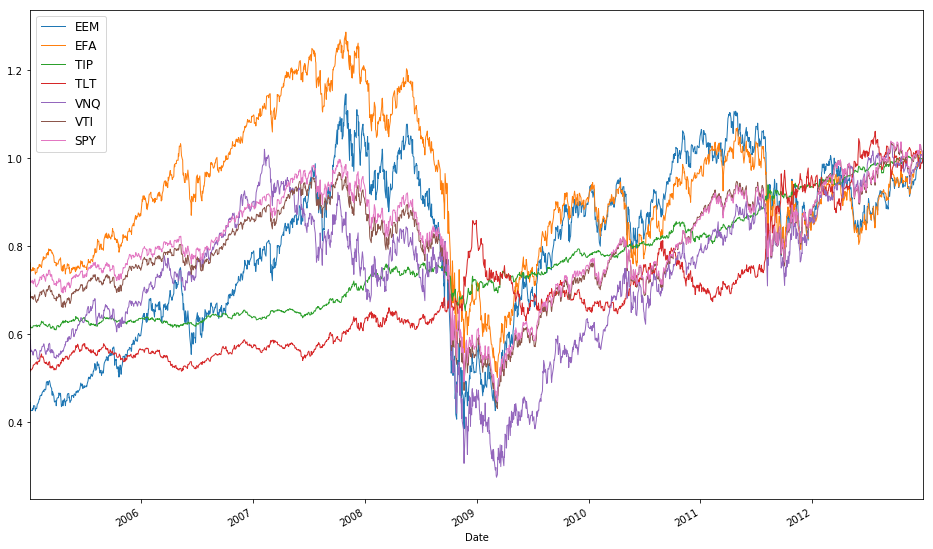

In [8]:
# plot normalized prices of the train set
ax1 = (train / train.iloc[0,:]).plot()
(train_b / train_b.iloc[0,:]).plot(ax=ax1)

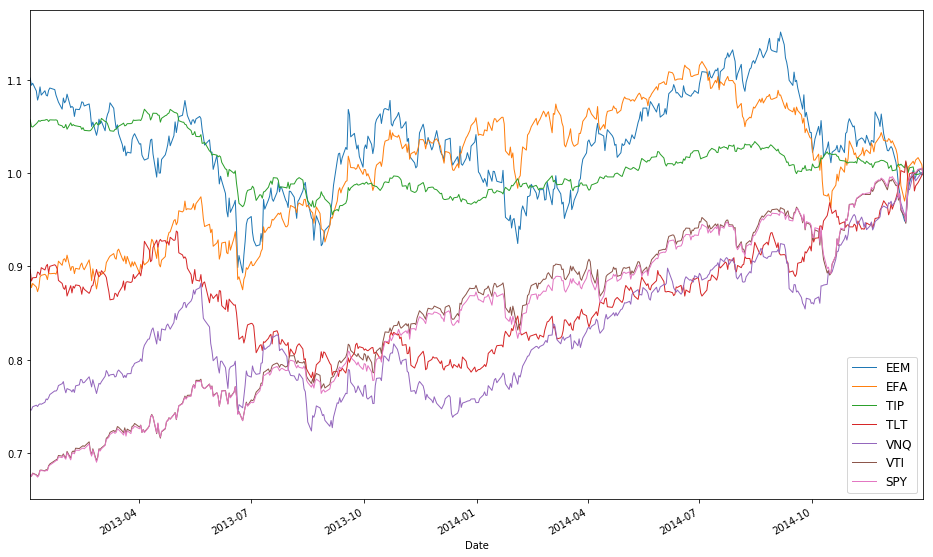

In [9]:
# plot normalized prices of the test set
ax2 = (test / test.iloc[0,:]).plot()
(test_b / test_b.iloc[0,:]).plot(ax=ax2)

# Comparing the Algorithms

We want to train on market data from a number of years, and test out of sample for a duration smaller than the train set. To get started we accept the default parameters for the respective algorithms and we essentially are just looking at two independent time periods.  In the future we will want to optimize the paramaters on the train set.

In [10]:
#list all the algos
olps_algos = [
algos.Anticor(),
algos.BAH(),
algos.BCRP(),
algos.BNN(),
algos.CORN(),
algos.CRP(b=swensen_allocation), # Non Uniform CRP (the Swensen allocation)
algos.CWMR(),
algos.EG(),
algos.Kelly(),
algos.OLMAR(),
algos.ONS(),
algos.PAMR(),
algos.RMR(),
algos.UP()
]

In [11]:
# put all the algos in a dataframe
algo_names = [a.__class__.__name__ for a in olps_algos]
algo_data = ['algo', 'results', 'profit', 'sharpe', 'information', 'annualized_return', 'drawdown_period','winning_pct']
metrics = algo_data[2:]
olps_train = pd.DataFrame(index=algo_names, columns=algo_data)
olps_train.algo = olps_algos

At this point we could train all the algos to find the best parameters for each.

In [12]:
# run all algos - this takes more than a minute
for name, alg in zip(olps_train.index, olps_train.algo):
    olps_train.ix[name,'results'] = alg.run(train)

2017-07-04 15:59:38,981 Running Anticor...
/home/ros/.conda/envs/python35/lib/python3.5/site-packages/universal/tools.py:254: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30,center=False).mean()
  ret[col] = rolling_m(ret[col], *args, **kwargs)
/home/ros/.conda/envs/python35/lib/python3.5/site-packages/universal/tools.py:270: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30,center=False).mean()
  RXY[:, i, j] = rolling_m(x[col_x] * y[col_y], **kwargs) - EX[col_x] * EY[col_y]
/home/ros/.conda/envs/python35/lib/python3.5/site-packages/universal/algos/anticor.py:43: UserWarning: scipy.weave is not available in python3, falling back to python version
  warnings.warn('scipy.weave is not available in python3, falling back to python version')
2017-07-04 15:59:39,339 Anticor finished successfully.
/home/ros/.conda/envs/

AttributeError: 'DatetimeIndex' object has no attribute 'order'

In [ ]:
# Let's make sure the fees are set to 0 at first
for k, r in olps_train.results.iteritems():
    r.fee = 0.0

In [ ]:
# we need 14 colors for the plot
n_lines = 14
color_idx = np.linspace(0, 1, n_lines)
mpl.rcParams['axes.color_cycle']=[plt.cm.rainbow(i) for i in color_idx]

In [ ]:
# plot as if we had no fees
# get the first result so we can grab the figure axes from the plot
ax = olps_train.results[0].plot(assets=False, weights=False, ucrp=True, portfolio_label=olps_train.index[0])
for k, r in olps_train.results.iteritems():
    if k == olps_train.results.keys()[0]: # skip the first item because we have it already
        continue
    r.plot(assets=False, weights=False, ucrp=False, portfolio_label=k, ax=ax[0])

In [ ]:
def olps_stats(df):
    for name, r in df.results.iteritems():
        df.ix[name,'profit'] = r.profit_factor
        df.ix[name,'sharpe'] = r.sharpe
        df.ix[name,'information'] = r.information
        df.ix[name,'annualized_return'] = r.annualized_return * 100
        df.ix[name,'drawdown_period'] = r.drawdown_period
        df.ix[name,'winning_pct'] = r.winning_pct * 100
    return df

In [ ]:
olps_stats(olps_train)
olps_train[metrics].sort('profit', ascending=False)

In [ ]:
# Let's add fees of 0.1% per transaction (we pay $1 for every $1000 of stocks bought or sold).
for k, r in olps_train.results.iteritems():
    r.fee = 0.001

In [ ]:
# plot with fees
# get the first result so we can grab the figure axes from the plot
ax = olps_train.results[0].plot(assets=False, weights=False, ucrp=True, portfolio_label=olps_train.index[0])
for k, r in olps_train.results.iteritems():
    if k == olps_train.results.keys()[0]: # skip the first item because we have it already
        continue
    r.plot(assets=False, weights=False, ucrp=False, portfolio_label=k, ax=ax[0])

### Notice how Kelly crashes right away and how RMR and OLMAR float to the top after some high volatility.  

In [ ]:
olps_stats(olps_train)
olps_train[metrics].sort('profit', ascending=False)

# Run on the Test Set

In [ ]:
# create the test set dataframe
olps_test  = pd.DataFrame(index=algo_names, columns=algo_data)
olps_test.algo  = olps_algos

In [ ]:
# run all algos
for name, alg in zip(olps_test.index, olps_test.algo):
    olps_test.ix[name,'results'] = alg.run(test)

In [ ]:
# Let's make sure the fees are 0 at first
for k, r in olps_test.results.iteritems():
    r.fee = 0.0

In [ ]:
# plot as if we had no fees
# get the first result so we can grab the figure axes from the plot
ax = olps_test.results[0].plot(assets=False, weights=False, ucrp=True, portfolio_label=olps_test.index[0])
for k, r in olps_test.results.iteritems():
    if k == olps_test.results.keys()[0]: # skip the first item because we have it already
        continue
    r.plot(assets=False, weights=False, ucrp=False, portfolio_label=k, ax=ax[0])

### Kelly went wild and crashed, so let's remove it from the mix

In [ ]:
# plot as if we had no fees
# get the first result so we can grab the figure axes from the plot
ax = olps_test.results[0].plot(assets=False, weights=False, ucrp=True, portfolio_label=olps_test.index[0])
for k, r in olps_test.results.iteritems():
    if k == olps_test.results.keys()[0] or k == 'Kelly': # skip the first item because we have it already
        continue
    r.plot(assets=False, weights=False, ucrp=False, portfolio_label=k, ax=ax[0])

In [ ]:
olps_stats(olps_test)
olps_test[metrics].sort('profit', ascending=False)

### Wow, ONS and OLMAR are at the bottom of the list. Remember, we really didn't do any training, but if we had selected ONS or OLMAR at the beginning of 2013 based on past performance, we would not have beat BAH. Hm.

# Focusing on OLMAR

Instead of using the default parameters, we will test several `window` parameters to see if we can get OLMAR to improve.

In [ ]:
# we need need fewer colors so let's reset the colors_cycle
mpl.rcParams['axes.color_cycle']= default_color_cycle

In [ ]:
train_olmar = algos.OLMAR.run_combination(train, window=[3,5,10,15], eps=10)
train_olmar.plot()

In [ ]:
print(train_olmar.summary())

In [ ]:
train_olmar = algos.OLMAR.run_combination(train, window=5, eps=[3,5,10,15])
train_olmar.plot()

In [ ]:
print(train_olmar.summary())

### We find that a window of 5 and eps are 5 are optimal over the train time period, but the default of w=5 and eps=10 were also fine for our purposes.

In [ ]:
# OLMAR vs UCRP
best_olmar = train_olmar[1]
ax1 = best_olmar.plot(ucrp=True, bah=True, weights=False, assets=False, portfolio_label='OLMAR')
olps_train.loc['CRP'].results.plot(ucrp=False, bah=False, weights=False, assets=False, ax=ax1[0], portfolio_label='CRP')

### On the train set OLMAR really delivers over CRP !

In [ ]:
# let's print the stats
print(best_olmar.summary())

### Let's see how individual ETFs contribute to portfolio equity.

In [ ]:
best_olmar.plot_decomposition(legend=True, logy=True)

### Let's highlight the magnitude of the highest contributing ETF by removing the log scale and looking at it directly.

In [ ]:
best_olmar.plot_decomposition(legend=True, logy=False)

### So VNQ (Real Estate) is the big driver after the market crash of 2008, which makes sense.

### Let's look at portfolio allocations

In [ ]:
best_olmar.plot(weights=True, assets=True, ucrp=False, logy=True, portfolio_label='OLMAR')

### VNQ is the big driver of wealth (log scale). Let's test the strategy by removing the most profitable stock and comparing Total Wealth.

In [ ]:
# find the name of the most profitable asset
most_profitable = best_olmar.equity_decomposed.iloc[-1].argmax()

# rerun algorithm on data without it
result_without = algos.OLMAR().run(train.drop([most_profitable], 1))

# and print results
print(result_without.summary())
result_without.plot(weights=False, assets=False, bah=True, ucrp=True, logy=True, portfolio_label='OLMAR-VNQ')

In [ ]:
result_without.plot_decomposition(legend=True, logy=False)

### Let's add fees of 0.1% per transaction (we pay \$1 for every \$1000 of stocks bought or sold).

In [ ]:
best_olmar.fee = 0.001
print(best_olmar.summary())
best_olmar.plot(weights=False, assets=False, bah=True, ucrp=True, logy=True, portfolio_label='OLMAR')

### The results now fall, with a Sharpe Ratio below the ~0.5 market Sharpe, and an annualized return that has been cut in half due to fees. It's as if all the trading makes OLMAR underperform for the first 4 years until it can grab some volatility in 2008 to beat UCRP.

### Let's look at OLMAR in the test time frame

In [ ]:
test_olmar = algos.OLMAR(window=5, eps=5).run(test)
#print(train_olmar.summary())
test_olmar.plot(ucrp=True, bah=True, weights=False, assets=False, portfolio_label='OLMAR')

### With fees

In [ ]:
test_olmar.fee = 0.001
print(test_olmar.summary())
test_olmar.plot(weights=False, assets=False, bah=True, ucrp=True, logy=True, portfolio_label='OLMAR')

# OLMAR Starting in 2010

The 2008-2009 recession was unique.  Let's try it all again starting in 2010, with a train set from 2010-2013 inclusive, and a test set of 2014.

In [ ]:
# set train and test time periods
train_start_2010= datetime(2010,1,1)
train_end_2010 = datetime(2013,12,31)
test_start_2010 = datetime(2014,1,1)
test_end_2010 = datetime(2014,12,31)

In [ ]:
# load data from Yahoo
train_2010 = DataReader(etfs, 'yahoo', start=train_start_2010, end=train_end_2010)['Adj Close']
test_2010  = DataReader(etfs, 'yahoo', start=test_start_2010,  end=test_end_2010)['Adj Close']

In [ ]:
# plot normalized prices of these stocks
(train_2010 / train_2010.iloc[0,:]).plot()

In [ ]:
# plot normalized prices of these stocks
(test_2010 / test_2010.iloc[0,:]).plot()

In [ ]:
train_olmar_2010 = algos.OLMAR().run(train_2010)
train_crp_2010 = algos.CRP(b=swensen_allocation).run(train_2010)
ax1 = train_olmar_2010.plot(assets=True, weights=False, ucrp=True, bah=True, portfolio_label='OLMAR')
train_crp_2010.plot(ucrp=False, bah=False, weights=False, assets=False, ax=ax1[0], portfolio_label='CRP')

In [ ]:
print(train_olmar_2010.summary())

In [ ]:
train_olmar_2010.plot_decomposition(legend=True, logy=True)

Not bad, with a Sharpe at 1 and no one ETF dominating the portfolio.  Now let's see how it fairs in 2014. 

In [ ]:
test_olmar_2010 = algos.OLMAR().run(test_2010)
test_crp_2010 = algos.CRP(b=swensen_allocation).run(test_2010)
ax1 = test_olmar_2010.plot(assets=True, weights=False, ucrp=True, bah=True, portfolio_label='OLMAR')
test_crp_2010.plot(ucrp=False, bah=False, weights=False, assets=False, ax=ax1[0], portfolio_label='CRP')

In [ ]:
print(test_olmar_2010.summary())

We just happen to be looking at a different time period and now the Sharpe drops below 0.5 and OLMAR fails to beat BAH.  Not good.

In [ ]:
test_olmar_2010.plot_decomposition(legend=True, logy=True)

# SPY / TLT portfolio comparison

Let's step back and simplify this by looking at OLMAR on a SPY and TLT portfolio.  We should also compare this portfolio to a rebalanced 70/30 mix of SPY and TLT.

In [ ]:
# load data from Yahoo
spy_tlt_data = DataReader(['SPY', 'TLT'], 'yahoo', start=datetime(2010,1,1))['Adj Close']

# plot normalized prices of these stocks
(spy_tlt_data / spy_tlt_data.iloc[0,:]).plot()

In [ ]:
spy_tlt_olmar_2010 = algos.OLMAR().run(spy_tlt_data)
spy_tlt_olmar_2010.plot(assets=True, weights=True, ucrp=True, bah=True, portfolio_label='OLMAR')

In [ ]:
spy_tlt_olmar_2010.plot_decomposition(legend=True, logy=True)

In [ ]:
print(spy_tlt_olmar_2010.summary())

In [ ]:
spy_tlt_2010 = algos.CRP(b=[0.7, 0.3]).run(spy_tlt_data)

ax1 = spy_tlt_olmar_2010.plot(assets=False, weights=False, ucrp=True, bah=True, portfolio_label='OLMAR')
spy_tlt_2010.plot(assets=False, weights=False, ucrp=False, bah=False, portfolio_label='CRP', ax=ax1[0])

## Now OLMAR looks better!

# OLMAR Market Sectors comparison

Let's look at algo behavior on market sectors:

- XLY Consumer Discrectionary SPDR Fund  
- XLF Financial SPDR Fund  
- XLK Technology SPDR Fund  
- XLE Energy SPDR Fund  
- XLV Health Care SPRD Fund  
- XLI Industrial SPDR Fund  
- XLP Consumer Staples SPDR Fund  
- XLB Materials SPDR Fund  
- XLU Utilities SPRD Fund  

In [ ]:
sectors = ['XLY','XLF','XLK','XLE','XLV','XLI','XLP','XLB','XLU']
train_sectors = DataReader(sectors, 'yahoo', start=train_start_2010, end=train_end_2010)['Adj Close']
test_sectors  = DataReader(sectors, 'yahoo', start=test_start_2010,  end=test_end_2010)['Adj Close']

In [ ]:
# plot normalized prices of these stocks
(train_sectors / train_sectors.iloc[0,:]).plot()

In [ ]:
# plot normalized prices of these stocks
(test_sectors / test_sectors.iloc[0,:]).plot()

In [ ]:
train_olmar_sectors = algos.OLMAR().run(train_sectors)
train_olmar_sectors.plot(assets=True, weights=False, ucrp=True, bah=True, portfolio_label='OLMAR')

In [ ]:
print(train_olmar_sectors.summary())

In [ ]:
train_olmar_sectors.plot(assets=False, weights=False, ucrp=True, bah=True, portfolio_label='OLMAR')

In [ ]:
test_olmar_sectors = algos.OLMAR().run(test_sectors)
test_olmar_sectors.plot(assets=True, weights=False, ucrp=True, bah=True, portfolio_label='OLMAR')

In [ ]:
test_olmar_sectors = algos.OLMAR().run(test_sectors)
test_olmar_sectors.plot(assets=False, weights=False, ucrp=True, bah=True, portfolio_label='OLMAR')

# All OLPS Algos Market Sectors comparison

In [ ]:
#list all the algos
olps_algos_sectors = [
algos.Anticor(),
algos.BAH(),
algos.BCRP(),
algos.BNN(),
algos.CORN(),
algos.CRP(),  # removed weights, and thus equivalent to UCRP
algos.CWMR(),
algos.EG(),
algos.Kelly(),
algos.OLMAR(),
algos.ONS(),
algos.PAMR(),
algos.RMR(),
algos.UP()
]

In [ ]:
olps_sectors_train = pd.DataFrame(index=algo_names, columns=algo_data)
olps_sectors_train.algo = olps_algos_sectors

In [ ]:
# run all algos - this takes more than a minute
for name, alg in zip(olps_sectors_train.index, olps_sectors_train.algo):
    olps_sectors_train.ix[name,'results'] = alg.run(train_sectors)

In [ ]:
# we need 14 colors for the plot
n_lines = 14
color_idx = np.linspace(0, 1, n_lines)
mpl.rcParams['axes.color_cycle']=[plt.cm.rainbow(i) for i in color_idx]

In [ ]:
# plot as if we had no fees
# get the first result so we can grab the figure axes from the plot
olps_df = olps_sectors_train
ax = olps_df.results[0].plot(assets=False, weights=False, ucrp=True, portfolio_label=olps_df.index[0])
for k, r in olps_df.results.iteritems():
    if k == olps_df.results.keys()[0]: # skip the first item because we have it already
        continue
    r.plot(assets=False, weights=False, ucrp=False, portfolio_label=k, ax=ax[0])

In [ ]:
# Kelly went wild, so let's remove it
# get the first result so we can grab the figure axes from the plot
olps_df = olps_sectors_train
ax = olps_df.results[0].plot(assets=False, weights=False, ucrp=True, portfolio_label=olps_df.index[0])
for k, r in olps_df.results.iteritems():
    if k == olps_df.results.keys()[0] or k == 'Kelly' : # skip the first item because we have it already
        continue
    r.plot(assets=False, weights=False, ucrp=False, portfolio_label=k, ax=ax[0])

In [ ]:
olps_stats(olps_sectors_train)
olps_sectors_train[metrics].sort('profit', ascending=False)

In [ ]:
# create the test set dataframe
olps_sectors_test  = pd.DataFrame(index=algo_names, columns=algo_data)
olps_sectors_test.algo  = olps_algos_sectors

In [ ]:
# run all algos
for name, alg in zip(olps_sectors_test.index, olps_sectors_test.algo):
    olps_sectors_test.ix[name,'results'] = alg.run(test_sectors)

In [ ]:
# plot as if we had no fees
# get the first result so we can grab the figure axes from the plot
olps_df = olps_sectors_test
ax = olps_df.results[0].plot(assets=False, weights=False, ucrp=True, portfolio_label=olps_df.index[0])
for k, r in olps_df.results.iteritems():
    if k == olps_df.results.keys()[0] : #or k == 'Kelly': # skip the first item because we have it already
        continue
    r.plot(assets=False, weights=False, ucrp=False, portfolio_label=k, ax=ax[0])

In [ ]:
# drop Kelly !
# get the first result so we can grab the figure axes from the plot
olps_df = olps_sectors_test
ax = olps_df.results[0].plot(assets=False, weights=False, ucrp=True, portfolio_label=olps_df.index[0])
for k, r in olps_df.results.iteritems():
    if k == olps_df.results.keys()[0] or k == 'Kelly': # skip the first item because we have it already
        continue
    r.plot(assets=False, weights=False, ucrp=False, portfolio_label=k, ax=ax[0])

In [ ]:
olps_stats(olps_sectors_test)
olps_sectors_test[metrics].sort('profit', ascending=False)

# Further work

- More algo's could be optimized for parameters before they are run against the test set
- In addition to the BAH, CRP and BCRP benchmarks, we could consider holding [SPY](https://www.google.com/finance?q=SPY) at 100% as a benchmark.
- Could look into BAH(OLMAR) and other combinations as this framework supports combining approaches directly
- Experiment with the ```run_subsets``` feature

# Conclusion

RMR and OLMAR do add value to a Lazy Portfolio if tested or run over a long enough period of time.  This gives RMR and OLMAR a chance to grab onto a period of volatility.  But in an up market (2013-1014) you want to Follow-the-Leader, not Follow-the-Looser.  Of the other algo's, CRP or BAH are decent, and maybe it's worth understanding what ONS is doing.